## Imports

In [1]:
import pandas as pd
import numpy as np
from SLP import SLP
from Adaline import Adaline
from Preprocessing import preprocessing

## Data Reading

In [2]:
all_data = pd.read_csv('birds.csv')

In [3]:
all_data.head()

,gender,body_mass,beak_length,beak_depth,fin_length,bird category
0,male,3750,39.1,18.7,181,A
1,female,3800,39.5,17.4,186,A
2,female,3250,40.3,18.0,195,A
3,female,3500,39.6,17.7,186,A
4,female,3450,36.7,19.3,193,A


## Data Slicing

### Feature Selecting

In [4]:
feature_index = {'gender':0,'body_mass':1, 'beak_length':2, 'beak_depth':3, 'fin_length':4}

In [5]:
feature1, feature2 = 'body_mass', 'beak_depth'  # will be taken from the gui
f1, f2 = feature_index[feature1], feature_index[feature2]

### Class Selecting 

In [6]:
class_index = {'A':0, 'B':1, 'C':2}

In [7]:
class1, class2 = 'B', 'C' # will be taken from the gui
b1, b2 = class_index[class1]*50, class_index[class2]*50
e1, e2 = b1+50, b2+50

print(f"Class {class1}: {b1} -> {e1}")
print(f"Class {class2}: {b2} -> {e2}")

Class B: 50 -> 100
Class C: 100 -> 150


### Slicing

In [8]:
C1 = all_data.iloc[b1:e1,[f1, f2, 5]]
C2 = all_data.iloc[b2:e2,[f1, f2, 5]]

print(C1.shape)
print(C2.shape)

(50, 3)
(50, 3)


In [9]:
# shuffle
C1 = C1.sample(frac=1).reset_index(drop=True)
C2 = C2.sample(frac=1).reset_index(drop=True)

## Data Splitting

In [10]:
train = pd.concat([C1.iloc[0:30], C2.iloc[0:30]])
test = pd.concat([C1.iloc[30:], C2.iloc[30:]])

print(train.shape)
print(test.shape)

(60, 3)
(40, 3)


In [11]:
# shuffle
train = train.sample(frac=1).reset_index(drop=True)
test = test.sample(frac=1).reset_index(drop=True)

In [12]:
train.head()

,body_mass,beak_depth,bird category
0,5700,14.3,B
1,5550,16.1,B
2,4050,18.1,C
3,3725,19.8,C
4,4750,15.0,B


In [13]:
X_train = train.iloc[:,0:2]
X_test = test.iloc[:,0:2]

print(X_train.shape)
print(X_test.shape)

(60, 2)
(40, 2)


In [14]:
X_train.head()

,body_mass,beak_depth
0,5700,14.3
1,5550,16.1
2,4050,18.1
3,3725,19.8
4,4750,15.0


In [15]:
Y_train = pd.DataFrame(train.iloc[:,2])
Y_test = pd.DataFrame(test.iloc[:,2])

print(Y_train.shape)
print(Y_test.shape)

(60, 1)
(40, 1)


In [16]:
Y_train.head()

,bird category
0,B
1,B
2,C
3,C
4,B


# Model

In [17]:
model_to_use, learning_rate, n_epochs = 'Adaline', 0.01, 30  # will be taken from the gui

if model_to_use == 'SLP':
    my_model = SLP(learning_rate=learning_rate, n_epochs=n_epochs)
elif model_to_use == 'Adaline':
    my_model = Adaline(learning_rate=learning_rate, n_epochs=n_epochs)

# Training

In [18]:
preprocessing(data=X_train)
preprocessing(data=Y_train, classes=[class1, class2])

In [19]:
X_train.head()

,body_mass,beak_depth
0,0.895522,0.155844
1,0.850746,0.389610
2,0.402985,0.649351
3,0.305970,0.870130
4,0.611940,0.246753


In [20]:
my_model.fit(X=X_train, Y=Y_train)

In [21]:
Y_train_pred = my_model.predict(X=X_train, column_name='bird category')
Y_train_pred.head()

,bird category
0,1
1,1
2,-1
3,-1
4,1


In [22]:
# my_model.plot_decision_boundary(X=X_train, Y=Y_train)

# Testing

In [23]:
preprocessing(data=X_test)
preprocessing(data=Y_test, classes=[class1, class2])

In [24]:
Y_test_pred = my_model.predict(X=X_test, column_name='bird category')
Y_test_pred.head()

,bird category
0,1
1,1
2,-1
3,-1
4,1


# Evaluation

## Train

In [25]:
accuracy = my_model.accuracy_score(Y=Y_train, Y_predict=Y_train_pred)
print(f"train accuracy = {accuracy}")

train accuracy = 1.0


In [26]:
confusion_matrix = my_model.confusion_matrix(Y=Y_train, Y_pred=Y_train_pred)
confusion_matrix

,Positive,Negative
Positive,30,0
Negative,0,30


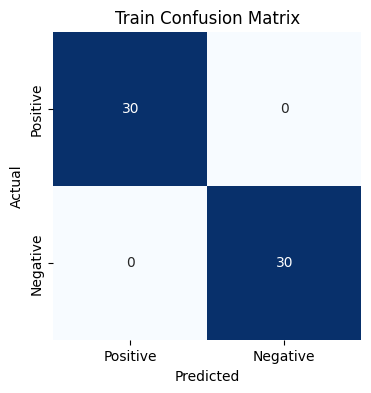

In [27]:
my_model.display_confusion_matrix(confusion_matrix, "Train Confusion Matrix")

## Test

In [28]:
accuracy = my_model.accuracy_score(Y=Y_test, Y_predict=Y_test_pred)
print(f"test accuracy = {accuracy}")

test accuracy = 1.0


In [29]:
confusion_matrix = my_model.confusion_matrix(Y=Y_test, Y_pred=Y_test_pred)
confusion_matrix

,Positive,Negative
Positive,20,0
Negative,0,20


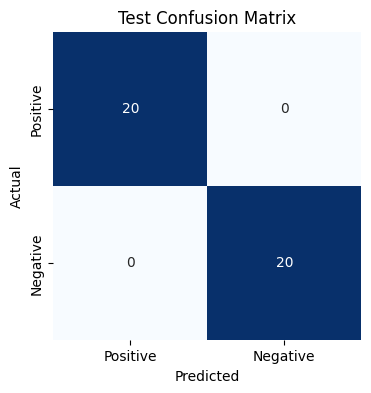

In [30]:
my_model.display_confusion_matrix(confusion_matrix, "Test Confusion Matrix")